<a href="https://colab.research.google.com/github/PouyaSonej/Semantic-Segmentation-Kitti-U-Net/blob/main/UNet_KITTI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.io
import cv2
import pdb
import os
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import plot_model

# Prepare Dataset

In [ ]:
!wget http://adas.cvc.uab.es/s2uad/Download/KITTI_SEMANTIC.zip

--2021-02-25 06:59:30--  http://adas.cvc.uab.es/s2uad/Download/KITTI_SEMANTIC.zip
Resolving adas.cvc.uab.es (adas.cvc.uab.es)... 158.109.8.54
Connecting to adas.cvc.uab.es (adas.cvc.uab.es)|158.109.8.54|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114312538 (109M) [application/zip]
Saving to: ‘KITTI_SEMANTIC.zip’

KITTI_SEMANTIC.zip  100%[===================>] 109.02M  6.83MB/s    in 18s     

2021-02-25 06:59:49 (6.01 MB/s) - ‘KITTI_SEMANTIC.zip’ saved [114312538/114312538]



In [ ]:
!unzip -q "/content/KITTI_SEMANTIC.zip"

In [ ]:
kitti_classes = {
    'Building':   [128, 0,   0],
    'Vegetation': [128, 128, 0],
    'Sky':        [128, 128, 128],
    'Car':        [64,  0,   128],
    'Sign':       [192, 128, 128],
    'Road':       [128, 64,  128],
    'Pedestrian': [64,  64,  0],
    'Fence':      [64,  64,  128],
    'Pole':       [192, 192, 128],
    'Sidewalk':   [0,   0,   192],
    'Cyclist':    [0,   128, 192],
}

class DataGenerator(keras.utils.Sequence):
    def __init__(self, path, batch_size=1, shuffle=True, subset='train'):
        self.path = path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.subset = subset

        rgb_path = path + '/RGB/'
        gt_path = path + '/GT/'

        self.images = []
        self.segments = []
        for name in np.sort(os.listdir(rgb_path)):
            rgb_name = rgb_path + name
            gt_name = gt_path + name

            rgb = cv2.imread(rgb_name)
            gt = cv2.imread(gt_name)
            gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

            # TODO: convert gt to categorical labels
            labels = np.zeros(gt.shape[:2])
            for i, (key, value) in enumerate(kitti_classes.items()):
              labels[np.sum(gt == value, axis=2) == 3] = i+1

            mask = labels == 0
            labels = keras.utils.to_categorical(labels-1, num_classes=len(kitti_classes))
            labels[mask==1, :] = 0

            self.images.append(rgb)
            self.segments.append(labels)

        self.on_epoch_end()

    # Denotes the number of batches per epoch
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    # Generate one batch of data
    def __getitem__(self, index):
        image = self.images[index]
        segment = self.segments[index]

        # TODO: Crop image to multiply of 16
        d0 = np.mod(image.shape[0], 16)
        d1 = np.mod(image.shape[1], 16)

        image = image[d0:, d1:, :]
        segment = segment[d0:, d1:, :]

        image = preprocess_input(image)

        if self.subset == 'train':
            # TODO: Apply random transforms
            if np.random.uniform() > 0.5:
                image = cv2.flip(image, 1)
                segment = cv2.flip(segment, 1)

        return np.expand_dims(image, axis=0), np.expand_dims(segment, axis=0)

    # Updates indices after each epoch
    def on_epoch_end(self):
        self.indices = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

train_generator = DataGenerator('/content/KITTI_SEMANTIC/Training_00')
valid_generator = DataGenerator('/content/KITTI_SEMANTIC/Validation_07', shuffle=False, subset='valid')

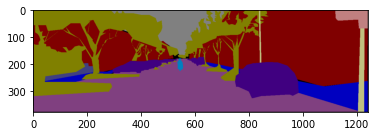

In [ ]:
gt = cv2.imread('/content/KITTI_SEMANTIC/Training_00/GT/000000.png')
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
plt.imshow(gt)

In [ ]:
labels = np.zeros(gt.shape[:2])
for i, (key, value) in enumerate(kitti_classes.items()):
  labels[np.sum(gt == value, axis=2) == 3] = i+1

mask = labels == 0
labels = keras.utils.to_categorical(labels-1, num_classes=len(kitti_classes))
labels[mask==1, :] = 0

# Train Model

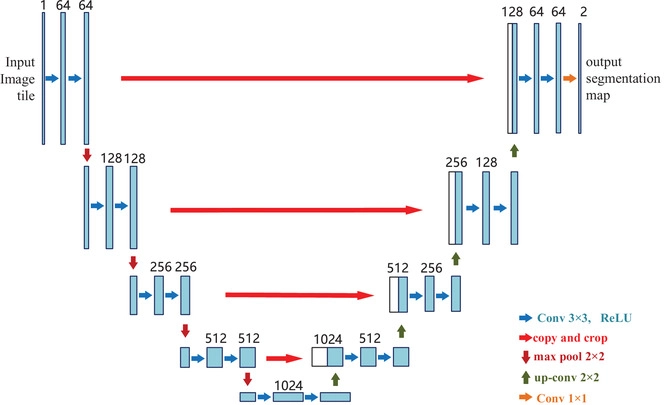

In [ ]:
# Define the U-Net architecture
def unet(input_shape=(256, 256, 3), num_classes=1):
    # Input layer
    inputs = Input(input_shape)

    # Encoder (contracting path)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom of the U-Net
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder (expansive path)
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(conv9)

    # Create the U-Net model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Instantiate the U-Net model
model = unet()
model.summary()
plot_model(model, show_shapes=True)

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0,
                                               patience=5,
                                               restore_best_weights=True)

# Train model on dataset
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=100,
                    callbacks=[early_stopping])

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
plot_metric(history, 'loss')
plot_metric(history, 'accuracy')

In [ ]:
X, Y_true = valid_generator.__getitem__(0)
Y_pred = model.predict(X)
print(Y_pred[0,0,0,:])

In [ ]:
np.sum(np.sum(Y_pred[0], axis=0), axis=0) / Y_pred.shape[2] / Y_pred.shape[1]

In [ ]:
plt.imshow(X[0])

# Batch-Normalization

In [ ]:
# load base model (encoder)
base_model = VGG16(include_top=False, weights='imagenet')

# select layers and freeze them
levels = []
for layer in base_model.layers:
    layer.trainable = False
    if layer.name.count('pool') > 0:
        levels.append(layer.input)

[f1, f2, f3, f4, f5] = levels

# activation = 'relu'
activation = keras.layers.LeakyReLU(alpha=0.2)

def conv_bn(x, filters):
  x = keras.layers.Conv2D(filters, 3, padding='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation(activation)(x)
  return x

# TODO: write decoder using UpSampling2D, Conv2D, and Concatenate layers


model = keras.models.Model(base_model.inputs, output)

plot_model(model, show_shapes=True)

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0,
                                               patience=5,
                                               restore_best_weights=True)

# Train model on dataset
history = model.fit_generator(generator=train_generator,
                              validation_data=valid_generator,
                              epochs=100,
                              shuffle=False,
                              callbacks=[early_stopping])

In [ ]:
!mkdir -p "/content/drive/My Drive/Datasets/Kitti"

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/Datasets/Kitti/model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/Datasets/Kitti/model.h5")

# Inference

In [ ]:
# load json and create model
json_file = open('/content/drive/My Drive/Datasets/Kitti/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/Datasets/Kitti/model.h5")
print("Loaded model from disk")

In [ ]:
X, Y_true = valid_generator.__getitem__(0)
Y_pred = model.predict(X)
print(Y_pred[0,0,0,:])